In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from toolz import curry

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

## Key Ideas

Important concepts covered are:
1. Elasticity (discrete and continuous cases) and  Conditional Average Treatment Effect  (CATE)
2. Cumulative elasticity curve
3. Cumulative gain curve.
4. We also review how to apply ML meta-learners to predict elasticity.

In [2]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices_rnd.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [3]:
np.random.seed(123)
train, test = train_test_split(prices_rnd)

We want to decide when to charge more or less depending on the day specific `weekday` and `cost`.

This means that elasticity will change with temperature, day of the week and cost.
 
$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X_i}*price_i + \pmb{\beta_3}X_i + e_i
$$

The unit level elasticity, or CATE, is given by
 
$$
\frac{\delta Sales}{\delta Price} = \beta_1 + \pmb{\beta_2 X_i}
$$
 
Where $\beta_1$ is the price coefficient and $\pmb{\beta_2}$ is the vector for the interaction coefficients. 

In [4]:
m = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

In [5]:
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,245.5934,3.426,71.684,0.000,238.876,252.310
C(weekday)[T.2],-90.1681,1.969,-45.804,0.000,-94.028,-86.309
C(weekday)[T.3],-89.9918,1.923,-46.788,0.000,-93.763,-86.221
C(weekday)[T.4],-92.8179,1.968,-47.164,0.000,-96.676,-88.959
C(weekday)[T.5],-89.8630,1.920,-46.799,0.000,-93.628,-86.098
C(weekday)[T.6],-94.3701,1.921,-49.125,0.000,-98.136,-90.604
C(weekday)[T.7],-0.6167,1.913,-0.322,0.747,-4.368,3.134
price,-11.2623,0.489,-23.036,0.000,-12.221,-10.304
price:C(weekday)[T.2],9.8965,0.286,34.623,0.000,9.336,10.457
price:C(weekday)[T.3],9.8761,0.276,35.821,0.000,9.336,10.417


The baseline $\beta1$ (the elasticity at $0C^o$)) is -11.26.
This means that, on average, as we increase price, sales go down, which makes sense. 
Notice that $\beta3$ is positive 0.04 which also means that for each additional degree in temperature, people become less sensitive to price increases on ice cream (although not by much).

For example, at $25C^o$, for each additional \\$ we charge, our sales go down by 10.26 units (-11.26 + (0.04 * 25)). 
But at $35C^o$, for each additional \\$ we charge, they go down only by 9.86 units . This is also sort of intuitive. As the days get hotter and hotter, people are willing to pay more for ice cream.

In [6]:
def pred_elasticity(m, df, t="price"):
    return df.assign(**{
        "pred_elast": m.predict(df.assign(**{t:df[t]+1})) - m.predict(df)
    })

In [7]:
pred_elast = pred_elasticity(m, test)

np.random.seed(1)
pred_elast.sample(5)

,temp,weekday,cost,price,sales,pred_elast
4764,31.1,6,1.0,3,212,1.144309
4324,24.8,7,0.5,10,182,-9.994303
4536,25.0,2,1.5,6,205,0.279273
3466,26.0,3,1.5,3,205,0.308320
115,19.3,3,0.3,9,177,-0.349745


Elasticity predictions indicate how much sales would change if we increased the price by one unit.
These predictions are not meant to be accurate, take a look at day 4764. It’s predicting a positive elasticity. In other words, we are predicting that sales will increase if we increase the price of ice cream. 
They help to segment the units by how sensitive they are to the treatment. 

We will now use a machine learning algorithm that uses price, temperature, weekday and cost as features  and tries to predict ice cream sales.

In [8]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"
ml2 = GradientBoostingRegressor()
ml2.fit(train[X], train[y])

# make sure the model is not overfiting.
R2 = ml2.score(test[X], test[y])
print(f"R2={R2}")

R2=0.9124088322890127


In [9]:
bands_df = pred_elast.assign(
    elast_band = pd.qcut(pred_elast["pred_elast"], 2), # create two groups based on elasticity predictions 
    pred_sales = ml2.predict(pred_elast[X]),
    pred_band = pd.qcut(ml2.predict(pred_elast[X]), 2), # create two groups based on sales predictions
)

bands_df.head()

,temp,weekday,cost,price,sales,pred_elast,elast_band,pred_sales,pred_band
2648,18.6,7,0.5,10,185,-10.301045,"(-10.597999999999999, -0.00555]",186.878081,"(161.089, 198.735]"
2456,26.0,3,0.5,10,200,0.036165,"(-0.00555, 1.389]",203.188327,"(198.735, 257.746]"
4557,23.7,3,0.3,8,192,-0.132057,"(-10.597999999999999, -0.00555]",188.800637,"(161.089, 198.735]"
4884,28.9,4,1.5,6,213,0.860663,"(-0.00555, 1.389]",210.430813,"(198.735, 257.746]"
92,23.7,1,0.5,8,207,-9.953698,"(-10.597999999999999, -0.00555]",209.044522,"(198.735, 257.746]"


Next, we need to compare which of these two segmentations is the best one.

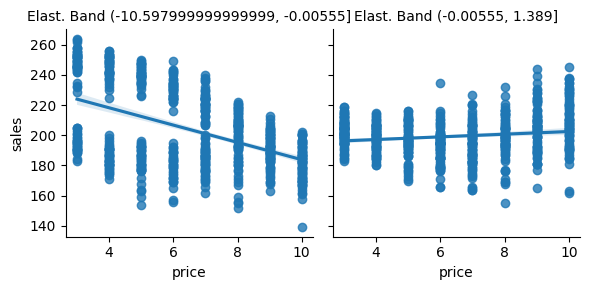

In [10]:
g = sns.FacetGrid(bands_df, col="elast_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Elast. Band {col_name}");

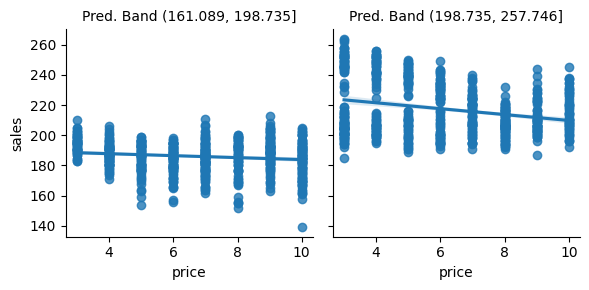

In [11]:
g = sns.FacetGrid(bands_df, col="pred_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Pred. Band {col_name}");

As you can see, the predictive model partitions are splitting the units on the y axis. On days like those in the first partition, we don’t sell a lot of ice cream, but we do sell more on days like those in the second partition. The prediction model predicts sales, it can distinguish between days where there will be low versus high ice cream sales.

Ultimately, we want to know when we can increase prices and when we can’t. But once we look at the slopes of the lines in the predictive model partitions, we see that they don’t change much. In other words, both partitions, as defined by the prediction model, have about the same responsiveness to price increase. This doesn’t offer us much insight into which are the days we can increase prices, since it looks like price is not affecting sales at all.

# Evaluation of the different causal models

We have random and non-random data, we keep the random version for evaluation purposes, non-randomness adds extra complexity to the evaluation.

In [12]:
prices = pd.read_csv("./data/ice_cream_sales.csv")
print(prices.shape)
prices.head()

(10000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


We create our first model with interactions terms so that elasticity is allowed to vary between units.

This means that elasticity will change with temperature, day of the week and cost.
 
$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X_i}*price_i + \pmb{\beta_3}X_i + e_i
$$

The unit level elasticity, or CATE, is given by
 
$$
\frac{\delta Sales}{\delta Price} = \beta_1 + \pmb{\beta_2 X_i}
$$
 
Where $\beta_1$ is the price coefficient and $\pmb{\beta_2}$ is the vector for the interaction coefficients. 

In [13]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

The second model is a nonparametric, machine learning, predictive model

$$
sales_i = G(X_i, price_i) + e_i
$$

In [14]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y])

GradientBoostingRegressor()

We check if we are not overfitting.

In [15]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


After training our models, we will get the elasticity from the regression model. Again, we will resort to a numerical approximation

$$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

In [16]:
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [17]:
def pred_elasticity(m, df, t="price", h=0.01):
    return (m.predict(df.assign(**{t:df[t]+h})) - m.predict(df))/ h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "elast_m_pred": pred_elasticity(m1, prices_rnd), ## elasticity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})


In [18]:
prices_rnd_pred.shape

(5000, 8)

In [19]:
prices_rnd_pred.head()

,temp,weekday,cost,price,sales,elast_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


Like previously, we segment the data into partitions of equal size and applies elasticity to each partition.

In [20]:
df_tmp = prices_rnd_pred.assign(**{"elast_m_pred_band": pd.cut(prices_rnd_pred["elast_m_pred"], 3)})
df_tmp.head()

,temp,weekday,cost,price,sales,elast_m_pred,pred_m_pred,rand_m_pred,elast_m_pred_band
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469,"(-18.802, -10.663]"
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139,"(-2.549, 5.565]"
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851,"(-18.802, -10.663]"
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315,"(-2.549, 5.565]"
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469,"(-18.802, -10.663]"


The elasticity in each partition is roughly the same as the ATE which is could be estimated by a single variable linear regression model.

$$
sales_i = \beta_0 + \beta_1 price_i + e_i
$$

From the theory of linear regression, we know that

$$
\hat{\beta_1}=\dfrac{\sum (price_i - \overline{price}) (sales_i - \overline{sales})}{\sum(price_i - \overline{price})^2}
$$

where $\overline{\text{price}}$ is the sample average for the treatment and $\overline{sales}$ is the sample average for the outcome. Here is what that looks like in code

In [21]:
np.sum((df_tmp["price"] - np.mean(df_tmp["price"])) * (df_tmp["sales"] - np.mean(df_tmp["sales"])))

-67276.38560000001

In [22]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

Generalizing the previous partition function and combining it with the function `elast`, we have

In [23]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t))) # estimate the elasticity on each partition

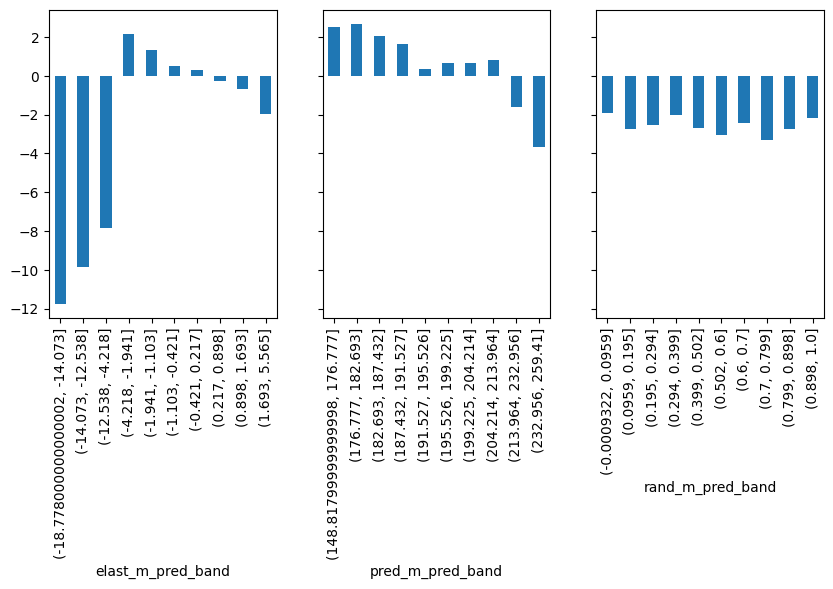

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["elast_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    elast_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

First, look at the random model (`rand_m`). It has roughly the same estimated elasticity in each of its partitions. We can already see just by looking at the plot that it won't help us much with personalisation since it can't distinguish between the high and low price elasticity days
So, what should we decide? Which one is more useful? The predictive or the causal model? The predictive model has better ordering, but the causal model can better identify the extremes. The elasticity by band plot is a good first check, but it can't answer precisely which model is better. We need to move to something more elaborate.

## Cumulative Elasticity Curve

Consider again the illustrative example where price was converted to a binary treatment. We will take it from where we left, so we had the elasticity of the treatment by band. What we can do next is order the band according to how sensitive they are. That is, we take the most sensitive group and place it in the first place, the second most sensitive group in the second place and so on. For both models 1 and 3, no re-ordering needs to be made, since they are already ordered. For model 2, we have to reverse the ordering. 

Once we have the ordered groups, we can construct what we will call the Cumulative Elasticity Curve. We first compute the elasticity of the first group; then, of the first and the second and so on, until we've included all the groups. In the end, we will just compute the elasticity for the entire dataset. Here is what it would look like for our illustrative example.

Notice that the first bin in the cumulative elasticity is just the ATE from the most sensitive group according to that model. Also, for all models, the cumulative elasticity will converge to the same point, which is the ATE for the entire dataset. 

Mathematically, we can define the cumulative elasticity as the elasticity estimated up until unit $k$. 

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

To build the cumulative elasticity curve, we run the above function iteratively in the dataset to produce the following sequence. 

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

This is a very interesting sequence in terms of model evaluation because we can make preferences statements about it. First, a model is better to the degree that

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

for any $k$ and $a>0$. In words, if a model is good at ordering elasticity, the elasticity observed in the top $k$ samples should be higher than the elasticity observed in top $k+a$ samples. Or, simply put, if I look at the top units, they should have higher elasticity than units below them. 

Second, a model is better to the degree that 

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

is the largest, for any $k$ and $a>0$. The intuition being that not only do we want the elasticity of the top $k$ units to be higher than the elasticity of the units below them, but we want that difference to be as large as possible. 

In [25]:
def cumulative_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

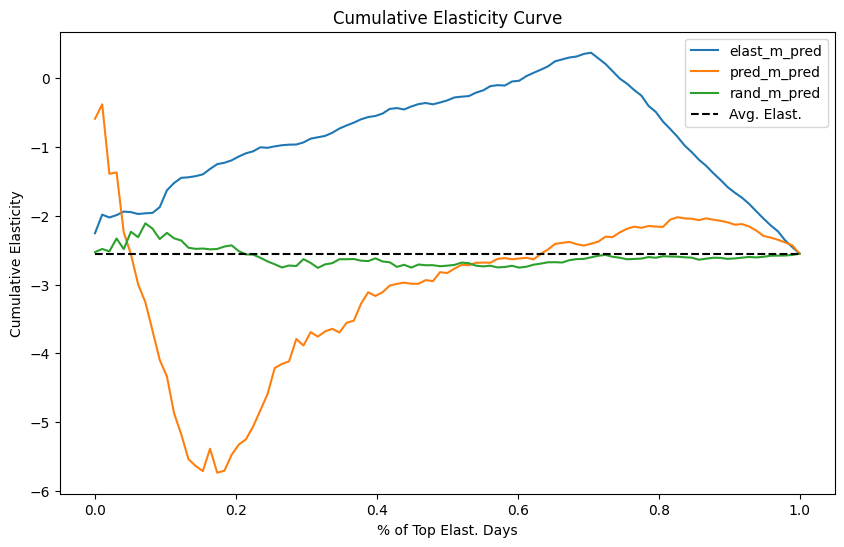

In [26]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_elast = cumulative_elast_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_elast)))
    plt.plot(x/x.max(), cumu_elast, label=m)

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

The X axis of the curve represents how many samples are we treating. Here,the X axis is normalized to be the proportion of the dataset, so .4 means we are treating 40% of the samples. The Y axis is the elasticity we should expect at that many samples. So, if a curve has value -1 at 40%, it means that the elasticity of the top 40% units is -1. Ideally, we want the highest elasticity for the largest  possible sample. An ideal curve then would start high up on the Y axis and descend very slowly to the average elasticity, representing we can treat a high percentage of units while still maintaining an above average elasticity. 

The random model `rand_m` oscillates around the average elasticity and never goes too far away from it. This means that the model can't find groups where the elasticity is different from the average one. 
As for the predictive model `pred_m`, it appears to be reversely ordering elasticity, because the curve starts below the average elasticity. Not only that, it also converges to the average elasticity pretty quickly, at around 50% of the samples. Finally, the causal model `elast_m` seems more interesting. Its cumulative elasticity increases away from the average, but then it reaches a point where we can treat about 75% of the units while keeping a pretty decent elasticity of almost 0.

In terms of model evaluation, the Cumulative Elasticity Curve is already much better than the simple idea of elasticity by band. Here, we managed to make preference statements about our models that were much more precise. Still, it's a complicated curve to understand. For this reason, we can do one further improvement.

## Cumulative Gain Curve

We will multiply the cumulative elasticity by the proportional sample size. For example, if the cumulative elasticity is, say -0.5 at 40%, we will end up with -0.2 (-0.5 * 0.4)  at that point. Then, we will compare this with the theoretical curve produced by a random model. This curve will actually be a straight line from 0 to the average treatment effect. 
Once we have the theoretic random curve, we can use it as a benchmark and compare our other models against it. All curves will start and end at the same point. However, the better the model at ordering elasticity, the more the curve will diverge from the random line in the points between zero and one. For example, in the image above, M2 is better than M1 because it diverges more before reaching the ATE at the end point. For those familiar with the ROC curve, you can think about Cumulative Gain as the ROC for causal models. 

Mathematically speaking, 

$$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$$


In [27]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [28]:
#cumulative_gain(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=100)

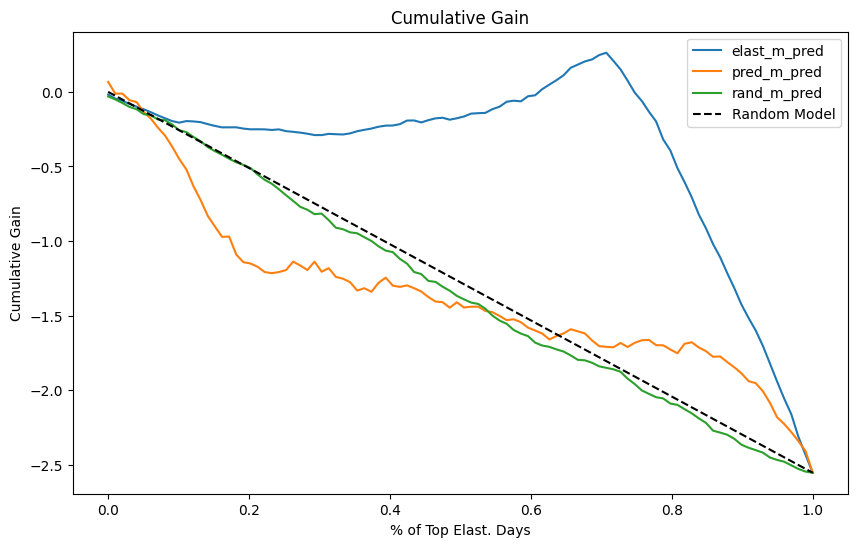

In [29]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

Now it is very clear that the causal model (`elast_m`) is much better than the other two. It diverges much more from the random line than both `rand_m` and `pred_m`. Also, notice how the actual random model follows very closely the theoretical random model. The difference between both is probably just random noise. 


## Taking Variance Into Account

It just feels wrong to not take variance into account when we are dealing with the elasticity curves. Specially since all of them use linear regression theory, so adding a confidence interval around them should be fairly easy.

To achieve that, we will first create a function that returns the CI for a linear regression parameter. I'm using the formula for the simple linear regression here, but feel free to extract the CI however you want.

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

In [30]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

In [31]:
elast_ci(prices_rnd_pred.head(50), "sales", "price")

array([-5.52575696, -0.63183779])

In [32]:
def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `elast` by a call to `elast_ci`
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

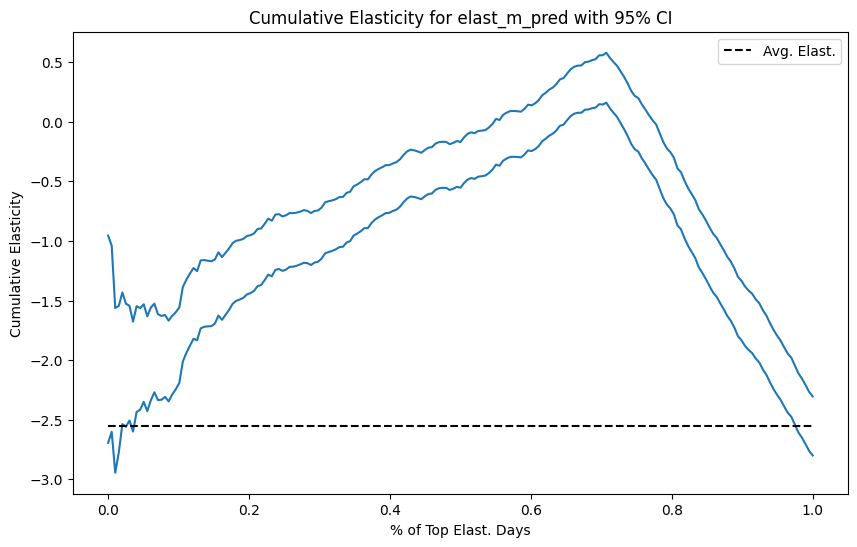

In [33]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_elast_curve_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity for elast_m_pred with 95% CI")
plt.legend();

In [34]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

Here is what it looks like for the causal model. Notice that now, the CI starts small, even though the sample size is smaller at the beginning of the curve. The reason is that the normalization factor $\frac{k}{N}$ shriks the ATE parameter and it's CI along with it. Since this curve should be used to compare models, this shouldn't be a problem, as the curve will apply this shirking factor equally to all the models being evaluated.

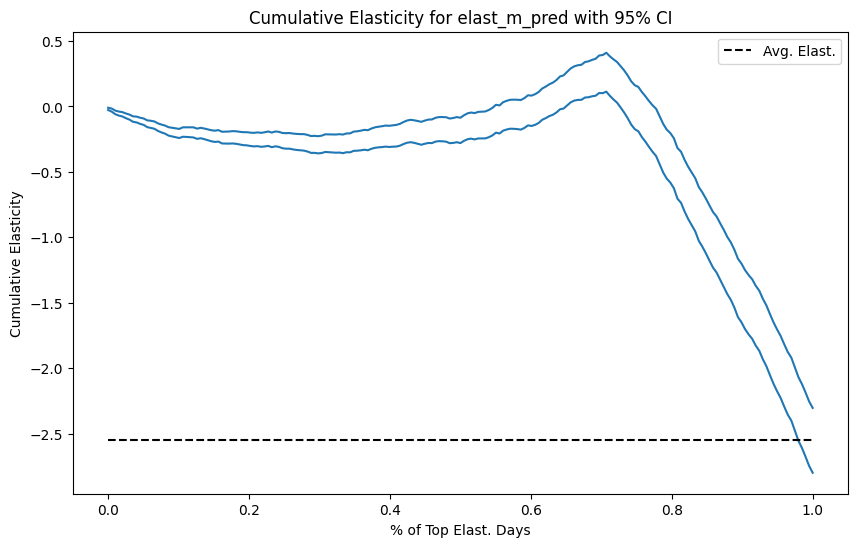

In [35]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_gain_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity for elast_m_pred with 95% CI")
plt.legend();

# Modification of the loss function for ML models

## Discrete Outcome Variable

What if we modify the loss function to predict the CATE itself? <br/>
Instead of minimising the outcome MSE
 
$
E[(Y_i - \hat{Y}_i)^2]
$
 
we would minimise the treatment effect MSE
 
$
E[(\tau(x)_i - \hat{\tau}(x)_i)^2] = E[(Y_i(1) - Y_i(0) - \hat{\tau}(x)_i)^2]
$
<br/>
where 
 
$
\tau_i = Y_i(1) − Y_i(0),
$
 
 
However, this criterion is infeasible. Again, the problem here is that $\tau(x)_i$ is not observable, so we can't optimize it directly. 

Also, we know that

$
Y_i*T_i = Y(1)_i*T_i \text{ and }  Y_i*(1-T_i) = Y(0)_i*T_i
$
<br/>
And 
<br/>
$
 E[T_i | X_i = x] = P(X_i), ~ P_i(X_i) \text{ is the propensity score}
$

Let's transform the target outcome variable
$
Y^*_i = Y_i * \dfrac{T_i - P(X_i)}{P(X_i)(1-P(X_i))}
$

If you take the expectation of this, you will see that it also matches the treatment effect.
$
\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - P(X_i)}{P(X_i)(1-P(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - P(X_i)}{P(X_i)(1-P(X_i))} + Y_i (1-T_i) * \dfrac{T_i - P(X_i)}{P(X_i)(1-P(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - P(X_i))}{P(X_i)(1-P(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)P(X_i)}{P(X_i)(1-P(X_i))}|X_i=x\big]\\
&= \dfrac{1}{P(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)| X_i=x]\\
&= \dfrac{1}{P(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-P(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}
$
 

## Continuous Outcome Variable

We wish to know that for each group the CATE, we condition on the features $X$
 
$
\tau(x) = E[\partial Y_i(t)|X] = E[\tau_i|X]
$

If this relationship is indeed linear, we can estimate those elasticities with the coefficient of a simple linear regression estimate. 
 
$$
\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}
$$
 
We can be inspired by this estimator and think about what it would be like for an individual unit. In other words, what if we have that same thing up there, defined as: 
$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

Let $ V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}$
<br/> Under random assignment $E[T_i|X_i=x]=\bar{T}$ and $E[V_i|X_i=x]=0$. 
<br/>
For every region of X, $E[T_i]=\bar{T}$, and $E[T_i V_i | X_i=x]=1$ because $E[T_i(T_i - \bar{T})|X_i=x] = E[(T_i - \bar{T})^2|X_i=x]$, which is the treatment variance. <br/> Finally, under conditional independence (which we get for free in the random treatment assignment case), $E[T_i P_i | X_i=x] = E[T_i | X_i=x] E[P_i | X_i=x]$.
 

We need to remember that we are estimating the parameter for a local linear model
 
$
Y_i = \alpha + \beta T_i + e_i | X_i=x
$
 
Here, we are interested in the $\beta$ parameter, which is our conditional elasticity or CATE. With all that, we can prove that
 
$
\begin{align}
E[Y^*_i|X_i=X] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + P_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[P_i V_i | X_i=x] \\
&= \beta + E[P_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}
$
 
This only works when the treatment is randomized. For non randomized treatment, we have to replace $\bar{T}$ by $M(X_i)$, where $M$ is a model that estimates $E[T_i|X_i=x]$. 
 
$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$
 
This will make sure that the term $\alpha E[V_i | X_i=x]$ in the third line vanishes to zero and that the term $E[T_i V_i | X_i=x]$ goes to 1.

In [36]:
import math

y_star_cont = (train["price"] - train["price"].mean()
               *train["sales"] - train["sales"].mean()) / math.sqrt(train["price"].var())

In [37]:
np.random.seed(1)
X = ["temp", "weekday", "cost"]
cate_learner = GradientBoostingRegressor()
cate_learner.fit(train[X], y_star_cont)
cate_test_transf_y = cate_learner.predict(test[X])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
3666,28.7,2,1.5,5,210,-692.572866
2362,17.1,6,1.5,4,186,-615.407961
146,23.6,2,0.3,4,193,-623.776743
558,17.8,3,0.3,10,167,-581.466498
1259,26.1,1,1.0,3,249,-707.561089


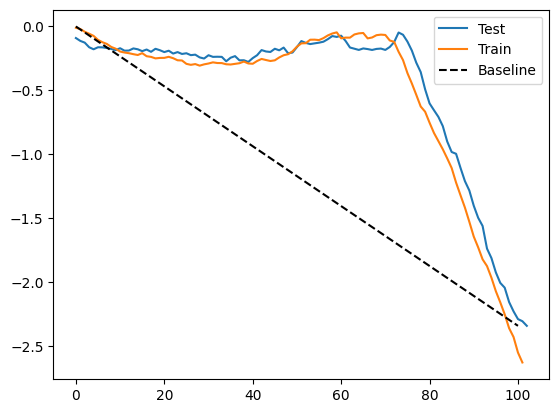

In [38]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y), "cate", y="sales", t="price")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="sales", t="price")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Baseline")
plt.legend();

For this data, it looks like the model with transformed target is way better than random.

In [39]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


In [40]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


In [41]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

In [42]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

In [43]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


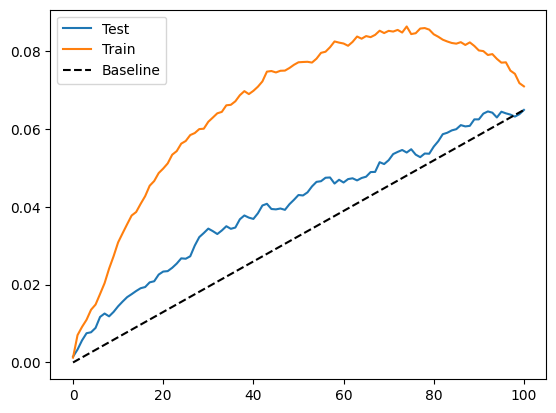

In [44]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

This estimator is better than random on the test set. Still, it looks like it is overfitting a lot, since the performance on the training set is much better than that of the test set.

## Meta-learners

In [45]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


In [46]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

# S-Learner

In [47]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

In [48]:
train[X].assign(**{T: 1})

,age,income,insurance,invested,em1
0,44.1,5483.80,6155.29,14294.81,1
1,39.8,2737.92,50069.40,7468.15,1
2,49.0,2712.51,5707.08,5095.65,1
3,39.7,2326.37,15657.97,6345.20,1
4,35.3,2787.26,27074.44,14114.86,1
...,...,...,...,...,...
14995,39.6,705.26,9110.88,1443.45,1
14996,45.8,3954.07,5572.26,15692.21,1
14997,42.5,1033.20,76005.87,2276.67,1
14998,44.0,11402.90,3187.30,45053.94,1


In [49]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

# T-Learner

In [50]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

# X-Learner

In [51]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

In [52]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

In [53]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,0)*mx0.predict(train[X]) +
                ps_predict(train,1)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,0)*mx0.predict(test[X]) +
                                ps_predict(test,1)*mx1.predict(test[X])))

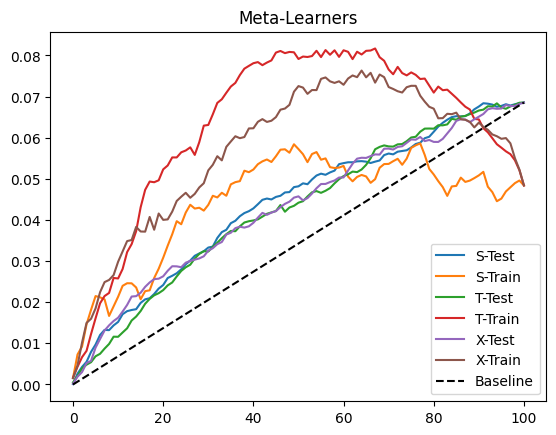

In [54]:
s_gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
s_gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(s_gain_curve_test, color="C0", label="S-Test")
plt.plot(s_gain_curve_train, color="C1", label="S-Train")
t_gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
t_gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(t_gain_curve_test, color="C2", label="T-Test")
plt.plot(t_gain_curve_train, color="C3", label="T-Train")
x_gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
x_gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(x_gain_curve_test, color="C4", label="X-Test")
plt.plot(x_gain_curve_train, color="C5", label="X-Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("Meta-Learners")
plt.show()
plt.close()

Here, the S, T and X learners seem to perform pretty similarly on the test data. 
- Perhaps because the treatment is not that weak.  Also, we can see that the training performance is much higher than the testing performance. This indicates the model is overfitting. This can happen because we are fitting each model on only a subset of the data. With less data points, the model is probably learning some noise.
- The T-Learner avoids the problem of not picking up on a weak treatment variable, but it can still suffer from regularization bias.
- Compared to the T-learner, the X-learner does a much better job in correcting the wrong CATE estimated at the non linearity. In general the X-learner performs better when a treatment group is much larger than the other.


# R-Learner

**Frisch-Waugh-Lovell** theorem tells us that 
if we regress the outcome on the features to get outcome residuals. Then, regress the treatment on the features to get treatment residuals. Finally, regress the outcome residuals on the feature residuals. This will yield the exact same estimate as if we regress the outcome on the features and treatment at the same time.


In other words:
$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$
 
which is essentially estimating the causal parameter $\tau$ in the following model
 
$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$
 

We now use ML models when constructing the outcome and treatment residuals: 
 
$
Y_i - \hat{M}_y(X_i)
= \tau(X_i) \cdot (T_i - \hat{M}_t(X_i)) + \hat{\epsilon}_i
$
 
where $\hat{M}_y(X_i)$ is estimating $E[Y|X]$ and  $\hat{M}_t(X_i)$ is estimating  $E[T|X]$.
 

If we rearrange the terms above, we can isolate the error term
 
$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$
 
This is nothing short of awesome, because now we can call this a **causal loss function**, which means that, if we minimize the square of this loss, we will be estimating expected value of $\tau(X_i)$, which is the CATE.
 
$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$
 
This loss is also called the **R-Loss**, since it's what the R-learner minimizes. First, let's rewrite the loss function we had before, but using the residualized version of treatment and outcome. 
 
$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$
 
Then take $\tilde{T}_i$ out of the parenthesis and isolate $\tau(X_i)$ in the square part of the loss function.
 
$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2 
$$
 
Minimising the above loss is equivalent to minimising what is inside the parenthesis, but weighting each term by $\tilde{T}_i^2$. Minimising what's inside the parenthesis is equivalent to predicting $\frac{\tilde{Y}_i}{\tilde{T}_i}$. This is what's called the weight trick to get the non-parametric causal loss. 

To summarise, we will
1. Create weights $\tilde{T}_i^2$
2. Create a target $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$
3. Use any prediction method to predict the target (2) while using the weights (1). 
 

First, we start orthogonalizing the treatment and the outcome with cross predictions from a ML model.

In [55]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(em1_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          converted_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

In [56]:
train_pred

,age,income,insurance,invested,em1,em2,em3,converted,em1_res,converted_res
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,-0.088629,-0.270129
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0.838357,-0.130827
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,-0.165398,0.751297
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,-0.167890,-0.138723
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0.861065,-0.089374
...,...,...,...,...,...,...,...,...,...,...
14995,39.6,705.26,9110.88,1443.45,1,0,0,0,0.299094,-0.140980
14996,45.8,3954.07,5572.26,15692.21,0,0,1,0,-0.122357,-0.236123
14997,42.5,1033.20,76005.87,2276.67,1,0,1,0,0.428509,-0.218776
14998,44.0,11402.90,3187.30,45053.94,0,0,1,0,-0.051826,-0.469960


Then we create the R-model which predicts weighted targets

In [57]:
r_model = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["em1_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["converted_res"] / train_pred["em1_res"])
 
# use a weighted regression ML model to predict the target with the weights.
r_model.fit(X=train[X], y=y_star, sample_weight=w);

In [58]:
# estimate the CATE
r_learner_cate_train = r_model.predict(train[X])
r_learner_cate_test = test.assign(cate=r_model.predict(test[X]))

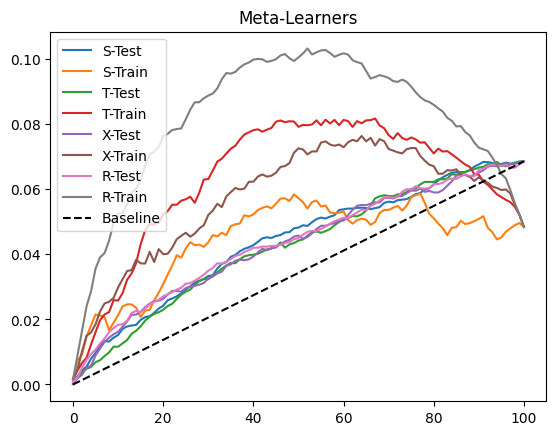

In [59]:
s_gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
s_gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(s_gain_curve_test, color="C0", label="S-Test")
plt.plot(s_gain_curve_train, color="C1", label="S-Train")
t_gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
t_gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(t_gain_curve_test, color="C2", label="T-Test")
plt.plot(t_gain_curve_train, color="C3", label="T-Train")
x_gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
x_gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(x_gain_curve_test, color="C4", label="X-Test")
plt.plot(x_gain_curve_train, color="C5", label="X-Train")
r_gain_curve_test = cumulative_gain(r_learner_cate_test, "cate", y="converted", t="em1")
r_gain_curve_train = cumulative_gain(train.assign(cate=r_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(r_gain_curve_test, color="C6", label="R-Test")
plt.plot(r_gain_curve_train, color="C7", label="R-Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("Meta-Learners")
plt.show()
plt.close()

Random data is usually expensive to access and we will reevaluae the models
using random data only for the test set

In [ ]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()